In [1]:
import numpy as np
import tensorflow as tf
from timeit import default_timer as timer
import matplotlib.pyplot as plt

# import utils.params as params
from utils.elapse import elapse_time
from utils.resources import print_resources
from utils.datapipeline import import_data, get_dataset
from utils.model import get_model
from utils.compiler import get_loss, get_optimizer, get_metric
from utils.callback import callback_list
from utils.results import print_train_plot, print_cm, print_cam, print_tsne

2024-05-22 12:48:25.840231: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.



*** RESOURCES ***
Tensorflow Version: 2.13.0
GPUs available: 0
CPUs available: 8

*** DATA ***
xtrain shape: (120, 64, 40)
xtest shape: (40, 64, 40)
ytrain shape: (120, 1)
ytest shape: (40, 1)
num agents: 10
num features: 40
num features per agent: 4
feature names: ['Px', 'Py', 'Vx', 'Vy']
num attribtues: 2
attributes: ['COMMS', 'PRONAV']
num classes: 4
classes: ['Greedy', 'Greedy+', 'Auction', 'Auction+']
xtrain sample (1st instance, 1st time step, all features)
 [1.32705844 1.46086507 1.11659847 1.26577168 1.17929836 1.15575297
 1.20623293 1.29326786 1.31072676 1.37238355 1.32161737 1.45720539
 1.20547716 1.55114439 1.1279954  1.45693892 1.31412004 1.38770303
 1.18002163 1.21335395 2.87744612 2.87909901 2.87997601 2.87640203
 2.88154982 2.88094564 2.87945294 2.8762162  2.87455756 2.877073
 2.87750987 2.87794248 2.88282671 2.8738496  2.87044708 2.8704715
 2.8788227  2.87861465 2.87358634 2.87159086]
ytrain sample (first instance) [0]

*** REDUCED OBSERVATION WINDOW ***
time steps ava

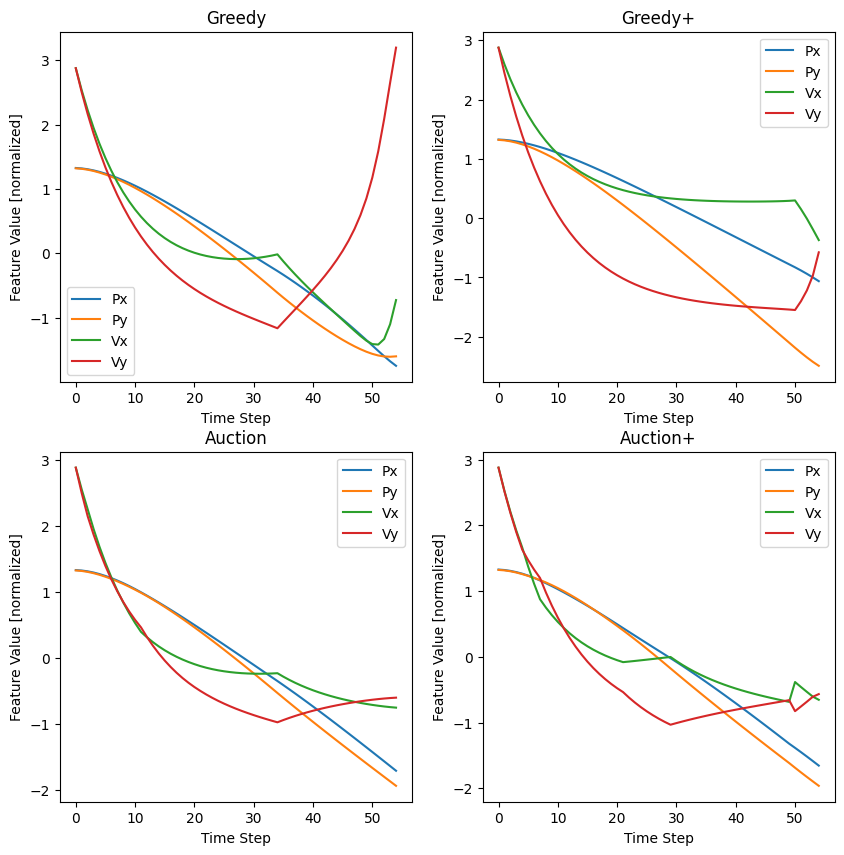

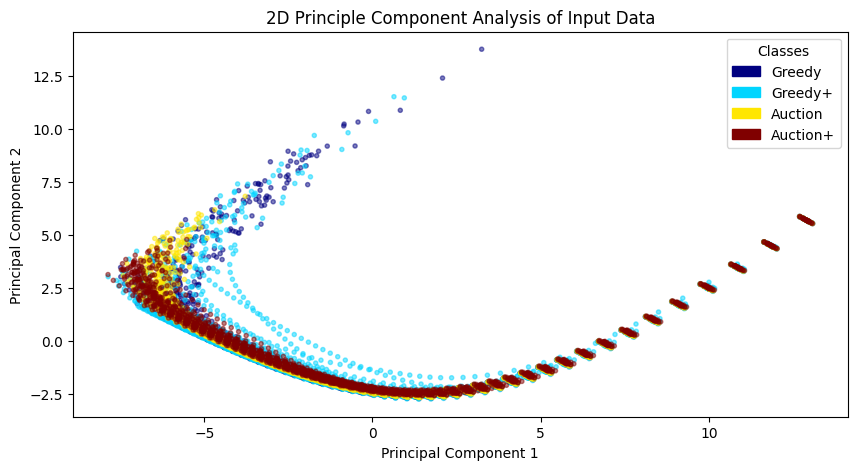

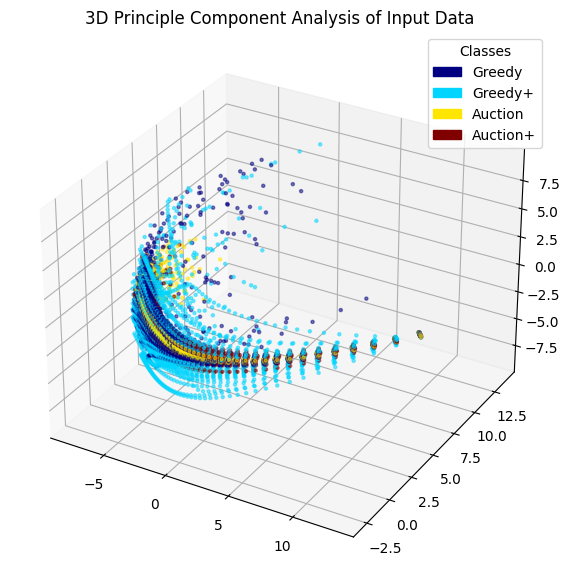

In [10]:
import argparse
import os
class Args(argparse.Namespace):
    mode="predict" 
    # trained_model="/Users/DWPeltier3/Library/CloudStorage/OneDrive-NavalPostgraduateSchool/1Documents/Research/swarm/models/CNmc20.keras" 
    trained_model="/Users/DWPeltier3/Library/CloudStorage/OneDrive-NavalPostgraduateSchool/1Documents/Research/swarm/models/CNmcFull.keras"
    # trained_model="/Users/DWPeltier3/Library/CloudStorage/OneDrive-NavalPostgraduateSchool/1Documents/Research/swarm/models/LSTMmc20tune.keras"
    # trained_model="/Users/DWPeltier3/Library/CloudStorage/OneDrive-NavalPostgraduateSchool/1Documents/Research/swarm/models/LSTMMmc20.keras"
    # trained_model="/Users/DWPeltier3/Library/CloudStorage/OneDrive-NavalPostgraduateSchool/1Documents/Research/swarm/models/LSTMMmcFull.keras"
    model_dir="/Users/DWPeltier3/Library/CloudStorage/OneDrive-NavalPostgraduateSchool/1Documents/Research/swarm/output/new/"
    data_path="/Users/DWPeltier3/Library/CloudStorage/OneDrive-NavalPostgraduateSchool/1Documents/Research/swarm/data/data_test.npz"
    
    # data_path="/Users/DWPeltier3/Library/CloudStorage/OneDrive-NavalPostgraduateSchool/1Documents/Research/swarm/data/data_10v10_perpendicular.npz" 
    # data_path="/Users/DWPeltier3/Library/CloudStorage/OneDrive-NavalPostgraduateSchool/1Documents/Research/swarm/data/data_10v10_straight.npz" 
    # data_path="/Users/DWPeltier3/Library/CloudStorage/OneDrive-NavalPostgraduateSchool/1Documents/Research/swarm/data/data_10v10_split.npz"
    # data_path="/Users/DWPeltier3/Library/CloudStorage/OneDrive-NavalPostgraduateSchool/1Documents/Research/swarm/data/data_10v10_semi.npz" 
    
    window=55
    features="pv"
    model_type="cn" 
    output_type="mc" 
    output_length="vec" 
    dropout=0.2 
    kernel_initializer="he_normal" 
    kernel_regularizer="none" 
    optimizer="adam" 
    initial_learning_rate=0.0001 
    callback_list="checkpoint, early_stopping, csv_log"
    patience=50
    num_epochs=1000
    batch_size=50
    val_split=0.2
    tune_type="h"
    tune_epochs=1000

hparams=Args()

## NOTES
# mode = 'train' or 'predict'
# window = -1 uses full window
# model_type = 'fc'=fully connect, 'cn'=CNN, 'fcn'=FCN, 'res'=ResNet, 'lstm'=long short term memory, 'tr'=transformer
# output_type = 'mc'=multiclass, 'ml'=multilabel, 'mh'=multihead
# output_length = 'vec'=vector (final only), 'seq'=sequence (every time step) **
#                                              ** only "lstm" or "tr" can have "seq" output
# kernel_initializer = "glorot_normal" "he_uniform/normal"
# kernel_regularizer = "none" "l1" "l2" "l1_l2"
#
# callback_list="checkpoint, early_stopping, csv_log"
#
# tune_type = tuner type: "r"=random, "b"=bayesian, "h"=hyperband
## INTRO
start = timer() # start timer to calculate run time
GPUs = print_resources() # computation resources available
# hparams = params.get_hparams() # parse BASH run-time hyperparameters (used throughout script below)
# params.save_hparams(hparams) # create model folder and save hyperparameters list .txt


## DEFINE LABELS
class_names = ['Greedy', 'Greedy+', 'Auction', 'Auction+']; hparams.class_names=class_names
attribute_names = ["COMMS", "PRONAV"]; hparams.attribute_names=attribute_names


## IMPORT DATA
x_train, y_train, x_test, y_test, cs_idx, input_shape, output_shape = import_data(hparams)
## CREATE DATASET OBJECTS (to allow multi-GPU training)
train_dataset, val_dataset, test_dataset = get_dataset(hparams, x_train, y_train, x_test, y_test)


## BUILD or LOAD MODEL

In [11]:
## BUILD & COMPILE MODEL
if hparams.mode == 'train':
    loss_weights=None #  single output head
    if hparams.output_type == 'mh': # multihead output
        loss_weights={'output_class':0.2,'output_attr':0.8}
        print(f"Loss Weights: {loss_weights}\n")
    if GPUs>1: # Multi-GPU
        print(f"GPUs availale: {GPUs}, MULTI GPU TRAINING")
        mirrored_strategy = tf.distribute.MirroredStrategy()
        print('Number of devices: {}'.format(mirrored_strategy.num_replicas_in_sync))
        with mirrored_strategy.scope():
            model = get_model(hparams, input_shape, output_shape)
            model.compile(
                loss=get_loss(hparams),
                optimizer=get_optimizer(hparams),
                metrics=get_metric(hparams),
                loss_weights=loss_weights)
    else: # single gpu
        model = get_model(hparams, input_shape, output_shape)
        model.compile(
            loss=get_loss(hparams),
            optimizer=get_optimizer(hparams),
            metrics=get_metric(hparams),
            loss_weights=loss_weights)

elif hparams.mode == 'predict':
    print(f'trained model: {hparams.trained_model}')
    model = tf.keras.models.load_model(hparams.trained_model)

if hparams.model_type!='tr':
    ## VISUALIZE MODEL
    model.summary()
    # make GRAPHVIZ plot of model
    # tf.keras.utils.plot_model(model, hparams.model_dir + "graphviz.png", show_shapes=True)



trained model: /Users/DWPeltier3/Library/CloudStorage/OneDrive-NavalPostgraduateSchool/1Documents/Research/swarm/models/CNmcFull.keras
Model: "CNN_mc"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 58, 40)]          0         
                                                                 
 conv1d_4 (Conv1D)           (None, 58, 224)           45024     
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 29, 224)           0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 29, 256)           172288    
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 15, 256)           0         
 g1D)                                                    

## Train Model (commented out)

In [ ]:

# ## TRAIN MODEL
# if hparams.mode == 'train':

#     # # USING DATA
#     # model_history = model.fit(
#     #     x_train,
#     #     y_train,
#     #     validation_split=hparams.train_val_split,
#     #     epochs=hparams.num_epochs,
#     #     batch_size=hparams.batch_size,
#     #     verbose=0,
#     #     callbacks=callback_list(hparams)
#     #     )

#     # USING DATASET
#     model_history = model.fit(
#         train_dataset,
#         validation_data=val_dataset,
#         epochs=50,
#         # epochs=hparams.num_epochs,
#         verbose=0,
#         callbacks=callback_list(hparams)
#         )
#     ## PRINT HISTORY KEYS
#     print("\nhistory.history.keys()\n", model_history.history.keys()) # this is what you want (only key names)
#     ## PRINT TRAINING ELAPSE TIME
#     elapse_time(start)
#     if hparams.model_type!='tr':
#         ## SAVE ENTIRE MODEL AFTER TRAINING
#         model.save(filepath=hparams.model_dir+"model.keras", save_format="keras") #saves entire model: weights and layout
#     ## TRAINING CURVE: ACCURACY/LOSS vs. EPOCH
#     print_train_plot(hparams, model_history)


## Predictions


*** TEST DATA RESULTS COMPARISON (10 per class) ***
    LABELS
True vs. Predicted

Greedy
[[0.00000000e+00 0.00000000e+00 9.99882281e-01 1.12014597e-04
  5.18451861e-06 5.26684289e-07]
 [0.00000000e+00 0.00000000e+00 8.25878620e-01 1.74088776e-01
  3.03403613e-05 2.37196900e-06]
 [0.00000000e+00 0.00000000e+00 9.84433889e-01 1.53373815e-02
  2.25055439e-04 3.57899398e-06]
 [0.00000000e+00 0.00000000e+00 9.94709611e-01 5.27683552e-03
  1.26079822e-05 9.22955053e-07]
 [0.00000000e+00 0.00000000e+00 9.98110831e-01 1.76097907e-03
  1.27751657e-04 3.84646313e-07]
 [0.00000000e+00 0.00000000e+00 6.19071245e-01 3.80821228e-01
  1.00589103e-04 7.01885983e-06]
 [0.00000000e+00 0.00000000e+00 9.75402236e-01 2.45692916e-02
  2.50336343e-05 3.38850236e-06]
 [0.00000000e+00 0.00000000e+00 9.97901320e-01 2.09167390e-03
  6.37793391e-06 6.47268621e-07]
 [0.00000000e+00 0.00000000e+00 9.98337686e-01 1.59306603e-03
  6.83961407e-05 8.25706707e-07]
 [0.00000000e+00 0.00000000e+00 9.97863412e-01 2.12258

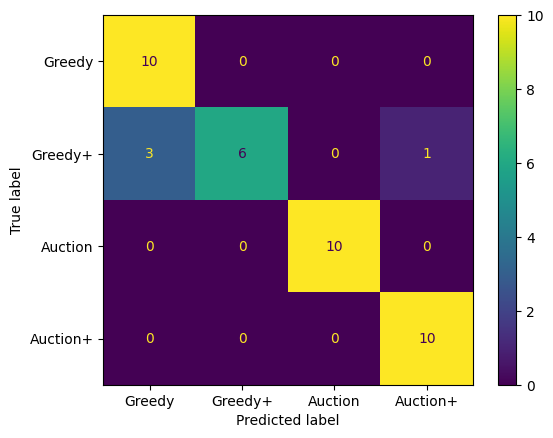

In [9]:
## TEST DATA PREDICTIONS
if hparams.output_type != 'mh':
    # pred=model.predict(x_test, verbose=0) #predicted label probabilities for test data
    pred=model.predict(test_dataset, verbose=0) #predicted label probabilities for test data
else: # multihead
    pred_class, pred_attr=model.predict(x_test, verbose=0) # multihead outputs 2 predictions (class and attribute)
# check for errors in requested output_length
output_length=hparams.output_length
if hparams.model_type!='lstm' and hparams.model_type!='tr': # only 'lstm' and 'tr' can output sequences
    output_length='vec'
# convert from probability (logits) to label
if hparams.output_type == 'mc' and output_length == 'vec':
    y_pred=np.argmax(pred,axis=1).reshape((-1,1))  #predicted class label for test data
elif hparams.output_type == 'mc' and output_length == 'seq':
    y_pred=np.argmax(pred,axis=2)  #predicted class label for test data
elif hparams.output_type == 'ml':
    y_pred=pred.round().astype(np.int32)  #predicted attribute label for test data
elif hparams.output_type == 'mh':
    y_pred_attr=pred_attr.round().astype(np.int32)
    if output_length == 'vec':
        y_pred_class=np.argmax(pred_class,axis=1).reshape((-1,1))
    else:
        y_pred_class=np.argmax(pred_class,axis=2)
    y_pred=[y_pred_class,y_pred_attr]
        

## TEST DATA PREDICTION SAMPLES
# np.set_printoptions(precision=2) #show only 2 decimal places for probability comparision (does not change actual numbers)
# print('\nprediction & label:\n',np.hstack((pred,y_test))) #probability comparison
num_results=10 # nunber of examples to view
class_names = ['Greedy', 'Greedy+', 'Auction', 'Auction+']
attribute_names = ["COMMS", "PRONAV"]
print(f'\n*** TEST DATA RESULTS COMPARISON ({num_results} per class) ***')
print('    LABELS\nTrue vs. Predicted')
if hparams.output_type != 'mh':
    for c in range(len(cs_idx)): # print each class name and corresponding prediction samples
        print(f"\n{class_names[c]}")
        # print(f"first true label: \n{y_test[cs_idx[c]]}")
        print(np.concatenate((y_test[cs_idx[c]:cs_idx[c]+num_results],
                            # y_pred[cs_idx[c]:cs_idx[c]+num_results]), axis=-1))
                            y_pred[cs_idx[c]:cs_idx[c]+num_results], 
                            pred[cs_idx[c]:cs_idx[c]+num_results]), axis=-1))
else: # multihead output
    for c in range(len(cs_idx)): # print each class name and corresponding prediction samples
        print(f"\n{class_names[c]}")
        print('class')
        print(np.concatenate((y_test[0][cs_idx[c]:cs_idx[c]+num_results],
                            y_pred_class[cs_idx[c]:cs_idx[c]+num_results]), axis=-1))
        print('attribute')
        print(np.concatenate((y_test[1][cs_idx[c]:cs_idx[c]+num_results],
                            y_pred_attr[cs_idx[c]:cs_idx[c]+num_results]), axis=-1))


## EVALUATE MODEL
# eval=model.evaluate(x_test, y_test, verbose=0) #loss and accuracy
eval=model.evaluate(test_dataset, verbose=0) #loss and accuracy
print('model.metrics_names:\n',model.metrics_names) #print evaluation metrics names (loss and accuracy)
print(eval) #print evaluation metrics numbers


## PRINT CONFUSION MATRIX
print_cm(hparams, y_test, y_pred)

In [ ]:

# ## PRINT TSNE DIMENSIONALITY REDUCTION
# if (hparams.output_length == 'vec') and (hparams.output_type != 'ml'): #could perform for each attribute separately...
#     perplexity=100
#     ## Input Data
#     tsne_input = x_test.reshape(x_test.shape[0],-1) # Reshape to (batch, time*feature); TSNE requires <=2 dim 
#     labels = y_test if hparams.output_type != 'mh' else y_test[0] # true labels
#     # if hparams.output_length == 'seq':
#     #     tsne_input = x_test.reshape(-1,x_test.shape[-1]) # (batch*time, features)
#     #     labels = labels.reshape(-1,1) # (batch*time,1) every time step is prediction
#     title="Input Data"
#     print_tsne(hparams, tsne_input, labels, title, perplexity)
#     ## Model Outputs
#     pre_output_layer=-4 if hparams.output_type == 'mh' else -2
#     model_preoutput = tf.keras.Model(inputs=model.input, outputs=model.layers[pre_output_layer].output)
#     tsne_input = model_preoutput(x_test)
#     labels = y_pred if hparams.output_type != 'mh' else y_pred_class # predicted labels
#     # if hparams.output_length == 'seq':
#     #     tsne_input = tsne_input.reshape(x_test.shape[0]*x_test.shape[1],-1) # (batch*time, other); **CAN'T perform np ops on tensor
#     #     labels = labels.reshape(-1,1) # (batch*time,1) every time step is prediction
#     title="Model Predictions"
#     print_tsne(hparams, tsne_input, labels, title, perplexity)


## PRINT CLASS ACTIVATION MAPS (if FCN model)
# only available if the model has a "Global Avg Pooling" layer and CONV layers
# if hparams.model_type=='fcn':
#     print_cam(hparams, model, x_train)


## PRINT ELAPSE TIME
elapse_time(start)